In [1]:
import path
with path.Path('../Utils'):
    import constant as c
    import functions as func
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import javalang
import pandas as pd
import os
from os.path import join
import glob
import numpy as np
import pprint
import pickle
import random
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report, f1_score
from imblearn.metrics import geometric_mean_score
import seaborn as sns
from sklearn.metrics import recall_score
from imblearn.metrics import specificity_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Input
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, Convolution1D, MaxPooling1D
from tensorflow.keras.layers import BatchNormalization, Dropout, concatenate
from tensorflow.keras import Model


In [2]:
def save_dict(obj, name ):
    with open('DATA/dictionarys/'+ name + '.pkl', 'wb') as ff:
        pickle.dump(obj, ff, pickle.HIGHEST_PROTOCOL)
        
def load_dict(name ):
    with open('DATA/dictionarys/' + name + '.pkl', 'rb') as ff:
        return pickle.load(ff)


In [3]:
def convert_words(previous, current, verbose= False):
    max_length = 0
    words = np.array([], dtype = 'object')
    for index, row in previous.iterrows():
        previous_file = 'DATA/embedded data'+row.pathfolder[7:]
        #print(previous_file)
        with open(previous_file, 'rb') as f: 
            m = 0
            for line in f:
                m += 1
                t = line.split()[0].decode('utf-8')

                words = np.append(words, t)

        if m > max_length:
            max_length = m
            max_file = previous_file

    

    for index, row in current.iterrows():
        current_file = 'DATA/embedded data'+row.pathfolder[7:]
        #print(previous_file)
        with open(current_file, 'rb') as f:
            m = 0
            for line in f:
                m +=1
                t = line.split()[0].decode('utf-8')

                words = np.append(words, t)

        if m > max_length:
            max_length = m
            max_file = current_file

    #k = words
    if verbose:
        print(len(words))           
        words = np.unique(words)
        print(words.shape)
        print('max lenght =' + str(max_length))
    
    
    print('convert_words finish')
    return max_length, words

In [4]:
def do_new_embedded(previous, current, dictionary, max_length):
    for index, row in previous.iterrows():
        vectors = np.array([])
        previous_file = 'DATA/embedded data'+row.pathfolder[7:]
        #print(row.pathfolder)
        Path(Path('DATA/new_embedded data'+row.pathfolder[7:]+'.embed').parent).mkdir(parents=True, exist_ok=True)
        #print(previous_file)
        with open(previous_file, 'rb') as f:
            for line in f:
                t = line.split()[0].decode('utf-8')
                #print(t, '=>', dictionary[t])
                vectors = np.append(vectors, dictionary[t])
        vectors = vectors.astype('int32')
        if vectors.shape[0] < max_length:
            new_lenght = max_length - vectors.shape[0]
            vectors = np.append(vectors, np.zeros(new_lenght))
        np.savetxt('DATA/new_embedded data'+row.pathfolder[7:]+'.embed', vectors, delimiter=',', fmt='%i')

    for index, row in current.iterrows():
        vectors = np.array([])
        current_file = 'DATA/embedded data'+row.pathfolder[7:]
        #print(row.pathfolder)
        Path(Path('DATA/new_embedded data'+row.pathfolder[7:]+'.embed').parent).mkdir(parents=True, exist_ok=True)
        #print(current_file)
        with open(current_file, 'rb') as f:
            for line in f:
                t = line.split()[0].decode('utf-8')
                #print(t, '=>', dictionary[t])
                vectors = np.append(vectors, dictionary[t])
        vectors = vectors.astype('int32')
        if vectors.shape[0] < max_length:
            new_lenght = max_length - vectors.shape[0]
            vectors = np.append(vectors, np.zeros(new_lenght))
        np.savetxt('DATA/new_embedded data'+row.pathfolder[7:]+'.embed', vectors, delimiter=',', fmt='%i')
        
    print('do_new_embedded finish')
    return

In [5]:
def generate_token(ant_token, version_tuple, verbose = False):
    if verbose:
        print(ant_token)
        #print('Tuple versions ->', version_tuple)
    previous = ant_token[ant_token['pathfolder'].str.contains((version_tuple[0]))].reset_index().drop(columns = ['index'])
    current = ant_token[ant_token['pathfolder'].str.contains((version_tuple[1]))].reset_index().drop(columns = ['index'])
    
    print('Conver words starting...')
    max_length, words = convert_words(previous, current)
    
    tokens = np.array(random.sample(range(words.shape[0]), words.shape[0]))
    dictionary = dict(zip(words, tokens))
    print('Conver words starting...')

    #save_dict(dictionary, 'ant-1.3 ant-1.4')
    
    print('Create new embedded files starting...')
    do_new_embedded(previous, current, dictionary, max_length)
    
    print('finish')
    
    print('Create Dataset For CNN starting...')
    train_X, train_y, test_X, test_y = create_trainset_forCNN(version_tuple, previous, current, verbose)
    
    print('Create the CNN Model')
    model = create_model(train_X, tokens)
    
    print('Generate Sematic Features')
    predicted_train, predicted_test= generate_new_features(model,train_X, train_y, test_X, test_y)
    
    print('Creating Dataset for Regressor')
    ntrain_X, ntrain_y, ntest_X, ntest_y = create_dataset_forClass(previous, current, version_tuple, predicted_train, predicted_test, verbose )
    
    print('Starting Regressor...')
    run_logisticRegression(ntrain_X, ntrain_y, ntest_X, ntest_y, verbose = True, plot = True)
    
    
    print('Finished')
    return
    

In [6]:
def create_trainset_forCNN(version_tuple, previous, current, verbose = False):
    ant_csv = glob.glob(c.mapped_data+'/ant*.csv')
    ant_token = []
    for i in ant_csv:
        tmp = pd.read_csv(i, names=['pathfolder', 'label'])
        ant_token.append(tmp)
    ant_token =pd.concat(ant_token)
    ant_token_sorted = ant_token.sort_values(by ='pathfolder')
    #ant_token =ant_token.reset_index().drop(['index'], axis= 1)
    ant_token_sorted =ant_token_sorted.reset_index().drop(['index'], axis= 1)
    previous = ant_token_sorted[ant_token_sorted['pathfolder'].str.contains(version_tuple[0])].reset_index()
    current = ant_token_sorted[ant_token_sorted['pathfolder'].str.contains(version_tuple[1])].reset_index().drop(columns = ['index'])
    
    vectors = []
    for index, row in previous.iterrows():
        previous_file = 'DATA/new_embedded data'+row.pathfolder[7:]
        #print(previous_file)
        with open(previous_file, 'rb') as f: 
            l = []
            for line in f:
                l.append(int(line.split()[0]))

        vectors.append(l)

    train_X = np.array(vectors)
    train_y = previous['label'].to_numpy()
    
    if verbose:
        print('train_X shape ->', train_X.shape)
    vectors = []
    for index, row in current.iterrows():
        previous_file = 'DATA/new_embedded data'+row.pathfolder[7:]
        #print(previous_file)
        with open(previous_file, 'rb') as f: 
            l = []
            for line in f:
                l.append(int(line.split()[0]))

        vectors.append(l)

    test_X = np.array(vectors)
    test_y = current['label'].to_numpy()
    
    return train_X, train_y, test_X, test_y

In [7]:
def create_model(train_X, tokens, n_filters= 10, filter_size = 2):

    model = models.Sequential()
    model.add(layers.Embedding(tokens.shape[0], 32, input_length=train_X.shape[1], embeddings_regularizer=tf.keras.regularizers.l2(l=0.0001)))
    model.add(
            Convolution1D(
                filters=n_filters,
                strides=2,
                kernel_size=filter_size,
                kernel_initializer="he_normal",

            ))
    model.add(Activation('relu'))
    model.add(MaxPooling1D())
    model.add(
            Convolution1D(
                filters=n_filters,
                strides=2,
                kernel_size=filter_size,
                kernel_initializer="he_normal",

            ))
    model.add(Activation('relu'))
    model.add(MaxPooling1D())
    model.add(
            Convolution1D(
                filters=n_filters,
                strides=2,
                kernel_size=filter_size,
                kernel_initializer="he_normal",

            ))
    model.add(Activation('relu'))
    model.add(MaxPooling1D())
    model.add(layers.Flatten())
    model.add(Dense( 50,kernel_regularizer= tf.keras.regularizers.l2(l=0.0001), kernel_initializer="he_normal"))
    model.add(Dropout(.5))
    model.add(Dense( 50,kernel_regularizer= tf.keras.regularizers.l2(l=0.0001), kernel_initializer="he_normal"))
    model.add(Dropout(.5))
    model.add(Dense( 50,kernel_regularizer= tf.keras.regularizers.l2(l=0.0001), kernel_initializer="he_normal"))
    model.add(Dropout(.5))
    model.add(Dense( 50,kernel_regularizer= tf.keras.regularizers.l2(l=0.0001), kernel_initializer="glorot_normal"))

    model.summary()
    
    return model

In [8]:
def generate_new_features(model, train_X, train_y, test_X, test_y):
    callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', min_delta=0.0001, patience=5)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0015), loss='binary_crossentropy', metrics=['accuracy'] )
    history = model.fit(train_X, train_y,epochs=50 ,callbacks=[callback], batch_size = 256,verbose=1 )
    
    predicted_train = model.predict(train_X)
    predicted_test = model.predict(test_X)
    
    return predicted_train, predicted_test

In [9]:
def create_dataset_forClass(previous, current, version_tuple,predicted_train, predicted_test, verbose = False):
    global DS3
    features = ['wmc', 'dit', 'noc', 'cbo', 'rfc', 'lcom',
       'ca', 'ce', 'npm', 'lcom3', 'loc', 'dam', 'moa', 'mfa', 'cam', 'ic',
       'cbm', 'amc', 'max_cc', 'avg_cc']
    ant_dataframe = []

    for filename in os.listdir(c.antCNN):
        tmp = pd.read_csv(join(c.antCNN, filename))
        ant_dataframe.append(tmp)
    ant_dataframe = pd.concat(ant_dataframe)
    previous_old = ant_dataframe.loc[ant_dataframe.version == float(version_tuple[0][-3:])].reset_index().drop(columns=['index'])
    current_old = ant_dataframe.loc[ant_dataframe.version == float(version_tuple[1][-3:])].reset_index().drop(columns=['index'])
    previous_old = previous_old.sort_values(by=['name']).reset_index().drop(columns=['index'])
    current_old = current_old.sort_values(by=['name']).reset_index().drop(columns=['index'])
    
    if DS3:
        D = func.create_D(current_old, previous_old, features, 'c')
        idx = func.runDS3(D, reg = .5, verbose = False)
        previous_old = previous_old.iloc[idx].reset_index().drop(columns=['index'])
        

        
    
    check = []
    ntrain_X = []
    ntrain_y = []
    for index, i in previous_old.iterrows():
        s = i['name']
        #print(s)
        for indexj, j in previous.iterrows():
            sj = j.pathfolder.replace('/', '.')
            #print(indexj)
            if (s in sj):
                #print(indexj)
                check.append(s)
    #             print(i[features])
    #             print(predicted_train[indexj])
                ntrain_X.append(np.concatenate((i[features], predicted_train[indexj]), axis = 0))
                ntrain_y.append(i['bug'])

                break
    check = []
    ntest_X = []
    ntest_y = []
    for index, i in current_old.iterrows():
        s = i['name']
        #print(s)
        for indexj, j in current.iterrows():
            sj = j.pathfolder.replace('/', '.')
            #print(indexj)
            if (s in sj):
                #print(indexj)
                check.append(s)
    #             print(i[features])
    #             print(predicted_train[indexj])
                ntest_X.append(np.concatenate((i[features], predicted_test[indexj]), axis = 0))
                ntest_y.append(i['bug'])

                break
    
    ntrain_X = np.array(ntrain_X)
    ntrain_X.shape
    ntrain_y = np.array(ntrain_y)
    ntrain_y.shape
    
    ntest_X = np.array(ntest_X)
    ntest_X.shape
    ntest_y = np.array(ntest_y)
    ntest_y.shape
    
    return ntrain_X, ntrain_y, ntest_X, ntest_y

In [10]:
def run_logisticRegression(train_X, train_y, test_X, test_y, verbose = False, plot = False):
    scaler = StandardScaler()
    scaler.fit(train_X)
    X_train = scaler.transform(train_X)
    y_train = train_y
    X_test = scaler.transform(test_X)
    y_test = test_y
    
    clf = LogisticRegression(solver = 'liblinear')
    clf = clf.fit(X_train, y_train)
    ##PREDICT##
    y_predicted = clf.predict(X_test)
    print(y_predicted)
    ##CALCULATE SCORE OF THE MODEL##
    score = clf.score(X_test, y_test)
    if True:
        print(f'- LogisticRegression score: {score}')
    # CONFUCIO MATRIX##
    cm = metrics.confusion_matrix(y_test, y_predicted)
    ##PLOT CONFUSION MATRIX##
    if plot:
        plt.figure(figsize=(9, 9))
        sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square=True, cmap='Blues_r');
        plt.ylabel('Actual label');
        plt.xlabel('Predicted label');
        #all_sample_title = 'Confusion matrix \n Accuracy Score: {0}\n {1} {2}'.format(score, previous.version[0], current.version[1])
        plt.ylabel('Actual label')
        plt.xlabel('Predicted label')
        #plt.title(all_sample_title, size=15);
    cmm = metrics.multilabel_confusion_matrix(y_test, y_predicted)
    if verbose:
        print("Confusion multiclass matrix :\n", cmm)
        print("CLASSIFICATION REPORT")
        print(classification_report(y_test, y_predicted))
        print("Accuracy:", metrics.accuracy_score(y_test, y_predicted))

    
############################################################################
############################################################################
#    'micro':
#     Calculate metrics globally by counting the total true positives, false negatives and false positives.
#
#   'macro':
#     Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.
############################################################################
############################################################################

    gmean = geometric_mean_score(y_test, y_predicted, average = 'micro')
    #print(cm)
    FP = cm.sum(axis=0) - np.diag(cm)
    FN = cm.sum(axis=1) - np.diag(cm)
    TP = np.diag(cm)
    TN = cm.sum() - (FP + FN + TP)

    # Sensitivity, hit rate, recall, or true positive rate
    #TPR = TP / (TP + FN)
    TPR = recall_score(y_test, y_predicted, average='micro')

    # Fall out or false positive rate
    #FPR = FP / (FP + TN)
    FPR = 1 - (specificity_score(y_test, y_predicted, average='micro'))
    
    #Balance
    balance = 1 - (np.sqrt((0 - FPR) ** 2 + (1 - TPR) ** 2) / np.sqrt(2))
    balance = np.average(balance)

    ##F MEASURE##
    fmeasure = f1_score(y_test, y_predicted, average = 'micro')

    if verbose:
        print('TPR :', TPR)
        print('FPR :', FPR)
        
    print('F-Measure : ', fmeasure)
    print('G-Mean :', gmean)
    print('Balance :', balance)

    '''filename = join(c.MODEL_DIR , 'digits_classifier.joblib.pkl')
    _ = joblib.dump(clf, filename, compress=9)
    '''
    

In [11]:
def start_run(verbose = False):
    ant_csv = glob.glob(c.mappednoembed_data + '/ant*.csv')
    ant_csv
    ant_token = []
    for i in ant_csv:
        tmp = pd.read_csv(i, names=['pathfolder', 'label'])
        ant_token.append(tmp)
    if verbose:
        print(ant_csv)
    ant_token = []
    for i in ant_csv:
        tmp = pd.read_csv(i, names=['pathfolder', 'label'])
        ant_token.append(tmp)
    ant_token =pd.concat(ant_token)
    versions = [i.split('\\')[2][:-4] for i in ant_csv]
    version_tuple = [(x, y) for x, y in zip(versions[0::1],versions[1::1])]
    if verbose:
        print(version_tuple)
    
    for v in version_tuple:
        print(v)
        generate_token(ant_token, v, verbose = verbose)
        #break
#     max_length, words = convert_words(versions)
    
#     do_new_embedded()
    

('ant-1.3', 'ant-1.4')
Conver words starting...
convert_words finish
Conver words starting...
Create new embedded files starting...
do_new_embedded finish
finish
Create Dataset For CNN starting...
Create the CNN Model
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 1246, 32)          2036448   
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 623, 10)           650       
_________________________________________________________________
activation_12 (Activation)   (None, 623, 10)           0         
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 311, 10)           0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 155, 10)           210       
__________________________________

C:\Users\roxil\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


1/1 [==============================] - 0s 1ms/step - loss: 2.6648 - accuracy: 0.0000e+00
Epoch 2/50
1/1 [==============================] - 0s 2ms/step - loss: 2.6992 - accuracy: 0.0081
Epoch 3/50
1/1 [==============================] - 0s 1000us/step - loss: 2.5207 - accuracy: 0.0161
Epoch 4/50
1/1 [==============================] - 0s 1ms/step - loss: 2.4213 - accuracy: 0.0161
Epoch 5/50
1/1 [==============================] - 0s 1ms/step - loss: 2.3635 - accuracy: 0.0000e+00
Epoch 6/50
1/1 [==============================] - 0s 2ms/step - loss: 2.3693 - accuracy: 0.0081
Epoch 7/50
1/1 [==============================] - 0s 2ms/step - loss: 2.3514 - accuracy: 0.0000e+00
Epoch 8/50
1/1 [==============================] - 0s 1ms/step - loss: 2.2955 - accuracy: 0.0000e+00
Creating Dataset for Regressor
Starting Regressor...
[1 0 1 0 0 0 0 0 0 2 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 3 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 

C:\Users\roxil\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


1/1 [==============================] - 0s 2ms/step - loss: 2.6742 - accuracy: 0.0056
Epoch 2/50
1/1 [==============================] - 0s 1ms/step - loss: 2.5983 - accuracy: 0.0000e+00
Epoch 3/50
1/1 [==============================] - 0s 2ms/step - loss: 2.5625 - accuracy: 0.0000e+00
Epoch 4/50
1/1 [==============================] - 0s 1ms/step - loss: 2.5702 - accuracy: 0.0113
Epoch 5/50
1/1 [==============================] - 0s 1ms/step - loss: 2.4602 - accuracy: 0.0000e+00
Epoch 6/50
1/1 [==============================] - 0s 999us/step - loss: 2.5521 - accuracy: 0.0056
Epoch 7/50
1/1 [==============================] - 0s 2ms/step - loss: 2.4572 - accuracy: 0.0056
Epoch 8/50
1/1 [==============================] - 0s 1ms/step - loss: 2.4067 - accuracy: 0.0056
Epoch 9/50
1/1 [==============================] - 0s 2ms/step - loss: 2.3385 - accuracy: 0.0000e+00
Creating Dataset for Regressor
Starting Regressor...
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 

C:\Users\roxil\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


2/2 [==============================] - 0s 20ms/step - loss: 1.6385 - accuracy: 0.0216
Epoch 2/50
2/2 [==============================] - 0s 21ms/step - loss: 1.4559 - accuracy: 0.0036
Epoch 3/50
2/2 [==============================] - 0s 20ms/step - loss: 1.3613 - accuracy: 0.0072
Epoch 4/50
2/2 [==============================] - 0s 22ms/step - loss: 1.2480 - accuracy: 0.0072
Epoch 5/50
2/2 [==============================] - 0s 22ms/step - loss: 1.1964 - accuracy: 0.0072
Epoch 6/50
2/2 [==============================] - 0s 21ms/step - loss: 1.1603 - accuracy: 0.0108
Creating Dataset for Regressor
Starting Regressor...
[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0
 0 0 1 1 1 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 1 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0
 1 1 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0
 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0
 

D:\anaconda\envs\tesi\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


convert_words finish
Conver words starting...
Create new embedded files starting...
do_new_embedded finish
finish
Create Dataset For CNN starting...
Create the CNN Model
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 3377, 32)          7733248   
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 1688, 10)          650       
_________________________________________________________________
activation_21 (Activation)   (None, 1688, 10)          0         
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 844, 10)           0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 422, 10)           210       
_________________________________________________________________
activation_22 (A

C:\Users\roxil\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


2/2 [==============================] - 0s 54ms/step - loss: 5.2039 - accuracy: 0.0314
Epoch 2/50
2/2 [==============================] - 0s 53ms/step - loss: 4.6511 - accuracy: 0.0086
Epoch 3/50
2/2 [==============================] - 0s 53ms/step - loss: 4.4902 - accuracy: 0.0143
Epoch 4/50
2/2 [==============================] - 0s 57ms/step - loss: 4.2466 - accuracy: 0.0114
Epoch 5/50
2/2 [==============================] - 0s 56ms/step - loss: 3.8456 - accuracy: 0.0171
Epoch 6/50
2/2 [==============================] - 0s 60ms/step - loss: 3.7895 - accuracy: 0.0143
Creating Dataset for Regressor
Starting Regressor...
[ 2  0  1  5  0  0  2  0  0  0  2 10  0  0  0  0  0  0  0  0  0  0  2  0
  0  2  0  0  5  0  0  0  1  0  1  1  0  0  0  2  0  0  2  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  1  1
  0  0  0  0  0  0  0  0  0  0  2  0  0  0  2  0  0  2  0  2  0  0  0  0
  0  0  0  0  0  0  0  2  0  0  3  0  2  0  0  0  0  0  0  0  3  0  1  0
  0  0  0  

D:\anaconda\envs\tesi\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


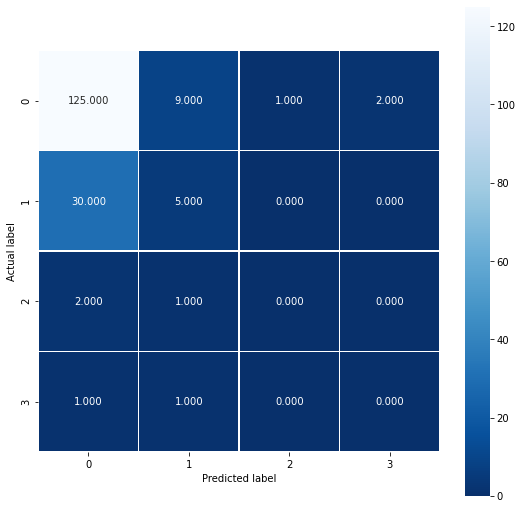

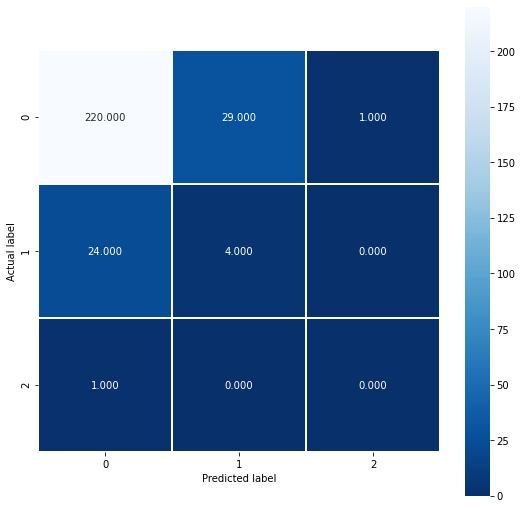

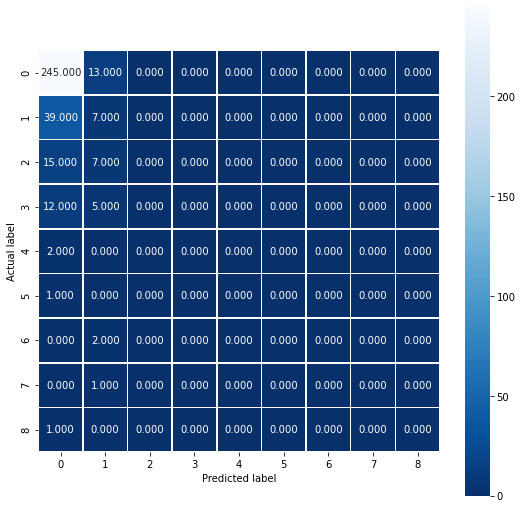

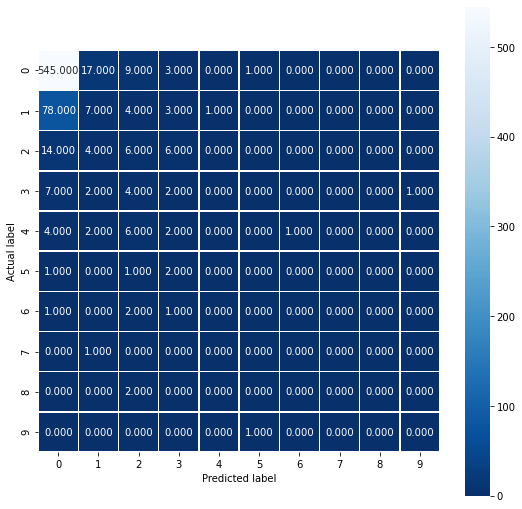

In [13]:
DS3 = False


start_run(verbose = False)